In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
os.chdir("/content/drive/MyDrive/patrones_personal")

In [17]:
!pip install pydicom
!pip install keras
!pip install tensorflow

# Challenge 7

Se utilizó la base de datos de Physionet: "VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs"

**Base de datos:**

Pham, H. H., Nguyen Trung, H., & Nguyen, H. Q. (2021). VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs (version 1.0.0). PhysioNet. https://doi.org/10.13026/q45h-5h59.

**Publicación original:**

Nguyen, H. T., Pham, H. H., Nguyen, N. T., Nguyen, H. Q., Huynh, T. Q., Dao, M., & Vu, V. (2021). VinDr-SpineXR: A deep learning framework for spinal lesions detection and classification from radiographs. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.2106.12930

**Physionet:**

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

## Exploración de los datos

Se cargó el csv con datos de los ids de las imágenes así como el tipo de lesión de cada una de ellas

In [18]:
import pandas as pd


file_path = './annotations/train.csv'
data = pd.read_csv(file_path)

data.head()


,study_id,series_id,image_id,rad_id,lesion_type,xmin,ymin,xmax,ymax
0,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,712.636842,961.361404,786.587719,1011.782456
1,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,789.949123,1452.126316,880.707018,1505.908772
2,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,692.468421,655.473684,746.250877,709.256140
3,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,820.201754,1603.389474,910.959649,1670.617544
4,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,739.528070,1203.382456,820.201754,1240.357895


## Extracción de labels e ids

Se escogieron 100 ids de imágenes correspondientes al tipo de lesión más común y 100 ids de imágenes sin lesiones presentes

In [26]:

lesion_counts = data[data['lesion_type'] != 'Other lesions']['lesion_type'].value_counts()
labels = lesion_counts.head(2).index.tolist()

labels_dict = {}

sample_ids = []
for lesion in labels:
    lesion_data = data[data['lesion_type'] == lesion]
    data_ids = lesion_data['image_id'].drop_duplicates().sample(n=100, random_state=1).tolist()


    sample_ids.extend(data_ids)
    labels_dict[lesion] = data_ids



# Append the ".dicom" extension to each image_id
sample_ids_dcm = [f"{id}.dicom" for id in sample_ids]

# Return the final list of DICOM file names and the top 5 lesions
labels, sample_ids_dcm[:10], len(sample_ids_dcm)


(['Osteophytes', 'No finding'],
 ['83c009224d6b55e5883676cbcf64ec64.dicom',
  'cb95796a816295241f316470b063cfb4.dicom',
  '04b73efa20766c684d0c1a1ee1572081.dicom',
  'a76f0d65604c020b37b996a58979ab5e.dicom',
  '6fe9940832799fc50e13a6e8a051ad9a.dicom',
  '9d014192d10ad72bf4c957f36cecef6c.dicom',
  'fe057071e07f9695d65ab079e3453585.dicom',
  '53a0affe8fabd9edea7044e56dc17187.dicom',
  '6ef55f57e3588e596499d87670da98ce.dicom',
  '00a4089038fb4f7b926624bd31b3ca88.dicom'],
 200)

In [20]:
len(labels_dict["No finding"])

100

## Ejemplo de ploteo de imagen

/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


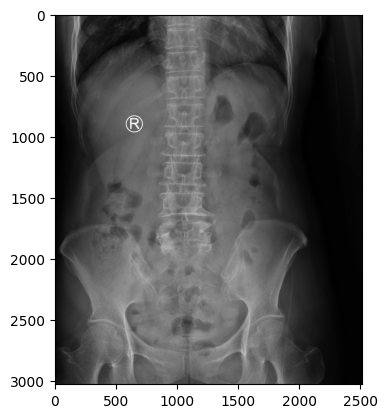

(3028, 2517)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom


# Cargar el archivo DICOM
dicom_path = f'./train_images/{labels_dict["Osteophytes"][26]}.dicom'
dicom_file = pydicom.dcmread(dicom_path)

# Extraer la imagen del archivo DICOM
image_data = dicom_file.pixel_array
fig, ax = plt.subplots(1)
# Mostrar la imagen

ax.imshow(image_data, cmap='gray')
#rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

# Añadir el rectángulo al plot
#ax.add_patch(rect)

plt.show()
image_data.shape



## Carga de las imágenes seleccionadas

Se cargaron las imágenes según los ids elegidos anteriormente, se redimensionaron las imágenes para que todas tengan el mismo tamaño.

/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


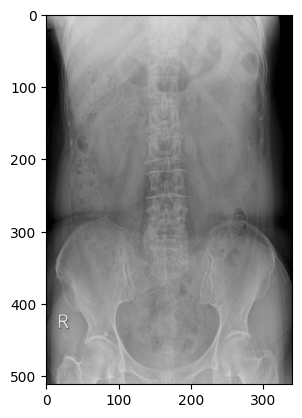

In [27]:
import os
import pydicom
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_dicom_images(directory, sample_ids):
    image_dimensions = []
    image_files = []
    for filename in sample_ids:
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path) and filename.endswith(".dicom"):
            dicom_img = pydicom.dcmread(file_path)
            rows, cols = dicom_img.pixel_array.shape
            image_dimensions.append((rows, cols))
            image_files.append(dicom_img)
    return image_files, image_dimensions

def find_common_aspect_ratio(dimensions):
    aspect_ratios = [dim[1] / dim[0] for dim in dimensions]
    mean_aspect_ratio = np.mean(aspect_ratios)
    return mean_aspect_ratio

def resize_images(images, target_height, target_aspect_ratio):
    resized_images = []
    for image in images:
        target_width = int(target_height * target_aspect_ratio)
        new_image = resize(image.pixel_array, (target_height, target_width), anti_aliasing=True)
        resized_images.append(new_image)
    return resized_images


directory = './train_images/'


images, dimensions = load_dicom_images(directory, sample_ids_dcm)
common_aspect_ratio = find_common_aspect_ratio(dimensions)
target_height = 512
resized_images = resize_images(images, target_height, common_aspect_ratio)

# Optionally display
plt.imshow(resized_images[0], cmap='gray')
plt.show()


Asignación de labels

In [28]:
id_to_label = {image_id: lesion_type for lesion_type, ids in labels_dict.items() for image_id in ids}

# Extraer las etiquetas correspondientes para cada ID de imagen con extensión .dicom
sample_ids_dcm = [f"{id}.dicom" for id in id_to_label.keys()]
labels2 = [id_to_label[id.replace('.dicom', '')] for id in sample_ids_dcm]

## Split del dataset

Se dividió el dataset en entrenamiento, test y validación usando la distribución 80-10-10.

In [62]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas a un formato numérico
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels2)

# Convertir etiquetas numéricas a one-hot
one_hot_encoded = to_categorical(integer_encoded)
resized_images_np = np.array(resized_images)
# Dividir los datos en entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(resized_images_np, one_hot_encoded, test_size=0.10, random_state=12, stratify=one_hot_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=12, stratify=y_train)  # 0.111 * 0.90 = 0.10
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Ejemplo para verificar las etiquetas codificadas
print("Ejemplo de etiquetas one-hot:", y_train[:5])


X_train shape: (160, 512, 341)
y_train shape: (160, 2)
X_val shape: (20, 512, 341)
y_val shape: (20, 2)
X_test shape: (20, 512, 341)
y_test shape: (20, 2)
Ejemplo de etiquetas one-hot: [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Creación del modelo de CNN

Se diseñó un modelo de red neuronal convolucional multicapa para la clasificación de las imágenes.

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape, num_classes):
    model = Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Tercera capa convolucional
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Aplanar las características para pasarlas a las capas densas
        Flatten(),

        # Capa densa
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Capa de salida
        Dense(num_classes, activation='softmax')
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


input_shape = (512, 341, 1)

model = create_model(input_shape, 2)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 512, 341, 32)      320       
                                                                 
 batch_normalization_9 (Bat  (None, 512, 341, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 256, 170, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 170, 64)      18496     
                                                                 
 batch_normalization_10 (Ba  (None, 256, 170, 64)      256       
 tchNormalization)                                               
                                                      

In [64]:

X_train = X_train[..., np.newaxis]  # Agregar la dimensión del canal
X_val = X_val[..., np.newaxis]

## Entrenamiento del modelo

In [66]:
import tensorflow as tf



# Configura el entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    epochs=200,  # Puedes ajustar el número de épocas según tus necesidades
    batch_size=64,  # Tamaño del lote
    validation_data=(X_val, y_val),
    verbose=1  # Para ver la salida detallada del entrenamiento
)


Epoch 1/200
3/3 [==============================] - 1s 343ms/step - loss: 34.3535 - accuracy: 0.6812 - val_loss: 12.9127 - val_accuracy: 0.5000
Epoch 2/200
3/3 [==============================] - 1s 336ms/step - loss: 22.1304 - accuracy: 0.7312 - val_loss: 13.5418 - val_accuracy: 0.5000
Epoch 3/200
3/3 [==============================] - 1s 347ms/step - loss: 33.3129 - accuracy: 0.7000 - val_loss: 13.9642 - val_accuracy: 0.5000
Epoch 4/200
3/3 [==============================] - 1s 339ms/step - loss: 24.7069 - accuracy: 0.7937 - val_loss: 11.7631 - val_accuracy: 0.5000
Epoch 5/200
3/3 [==============================] - 1s 346ms/step - loss: 14.9746 - accuracy: 0.8125 - val_loss: 11.1926 - val_accuracy: 0.5000
Epoch 6/200
3/3 [==============================] - 1s 347ms/step - loss: 8.7480 - accuracy: 0.8000 - val_loss: 12.5514 - val_accuracy: 0.5000
Epoch 7/200
3/3 [==============================] - 1s 367ms/step - loss: 28.7204 - accuracy: 0.7563 - val_loss: 15.0019 - val_accuracy: 0.5000


## Identificación de overfitting

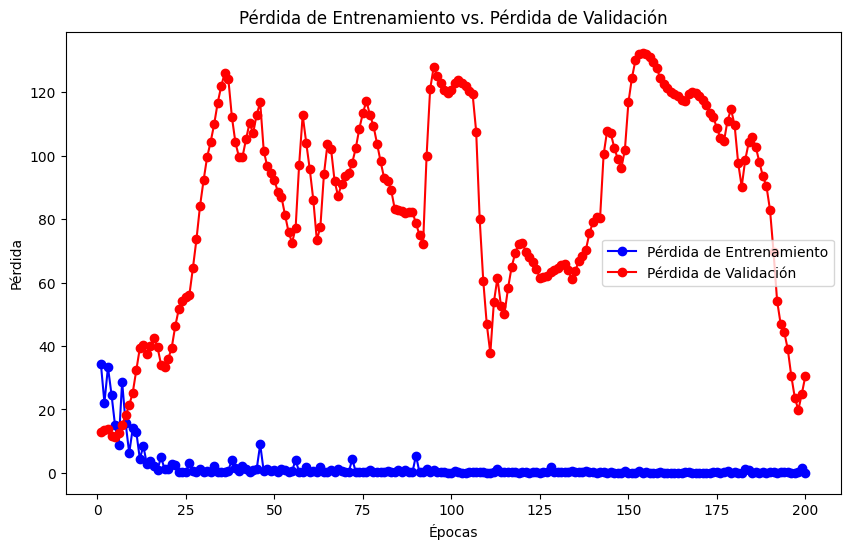

In [67]:
import matplotlib.pyplot as plt

# Extraer los valores de pérdida de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un rango de épocas para el eje X
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento vs. Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [68]:
X_test = X_test[..., np.newaxis]  # Asegúrate de que X_test tenga la dimensión del canal correcta



In [69]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Precisión en el conjunto de prueba:", test_acc)

1/1 [==============================] - 0s 74ms/step - loss: 38.0816 - accuracy: 0.5000
Precisión en el conjunto de prueba: 0.5


## Diseño de un nuevo modelo

Se aplicó dropout para simplificar el modelo y se introdujo regularización L2 con el fin de reducir el overfitting y mejorar los resultados.

In [72]:
def create_regularized_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  # Dimensiones de entrada basadas en las imágenes procesadas
input_shape = (512, 341, 1)  # Asumiendo que las imágenes son en escala de grises

# Crear el modelo
model = create_regularized_model(input_shape, 2)

# Resumen del modelo
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 512, 341, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 256, 170, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 170, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 128, 85, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 348160)            0         
                                                                 
 dense_10 (Dense)            (None, 64)               

## Entrenamiento del modelo revisado

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

# Asume que ya tienes un modelo llamado 'model'
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


Epoch 1/200
3/3 [==============================] - 8s 1s/step - loss: 3.2449 - accuracy: 0.4375 - val_loss: 1.3202 - val_accuracy: 0.5000
Epoch 2/200
3/3 [==============================] - 0s 125ms/step - loss: 1.7738 - accuracy: 0.5312 - val_loss: 1.6329 - val_accuracy: 0.7500
Epoch 3/200
3/3 [==============================] - 0s 117ms/step - loss: 1.5901 - accuracy: 0.5875 - val_loss: 1.3731 - val_accuracy: 0.6500
Epoch 4/200
3/3 [==============================] - 0s 122ms/step - loss: 1.7676 - accuracy: 0.5250 - val_loss: 1.3829 - val_accuracy: 0.5500
Epoch 5/200
3/3 [==============================] - 0s 183ms/step - loss: 1.3784 - accuracy: 0.5250 - val_loss: 1.2359 - val_accuracy: 0.7500
Epoch 6/200
3/3 [==============================] - 0s 175ms/step - loss: 1.2578 - accuracy: 0.5188 - val_loss: 1.2112 - val_accuracy: 0.5500
Epoch 7/200
3/3 [==============================] - 0s 177ms/step - loss: 1.2183 - accuracy: 0.5750 - val_loss: 1.1884 - val_accuracy: 0.5500
Epoch 8/200
3/3 

## Verificación de resultado

Se obtuvo un mejor accuracy y se redujeron significativamente las diferencias entre la pérdida de validación y de entrenamiento, reduciendo el overfitting con éxito.

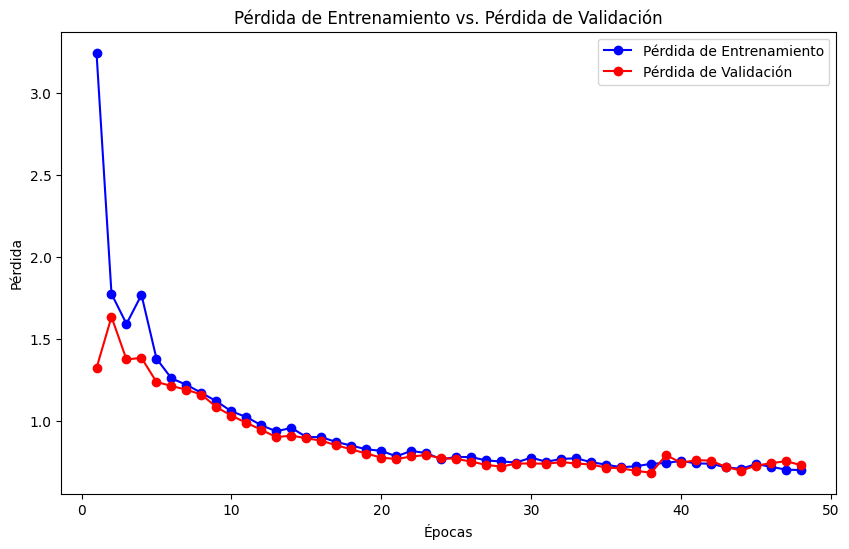

In [75]:
import matplotlib.pyplot as plt

# Extraer los valores de pérdida de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un rango de épocas para el eje X
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento vs. Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


In [76]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


1/1 - 0s - loss: 0.8069 - accuracy: 0.6000 - 50ms/epoch - 50ms/step

Test accuracy: 0.6000000238418579


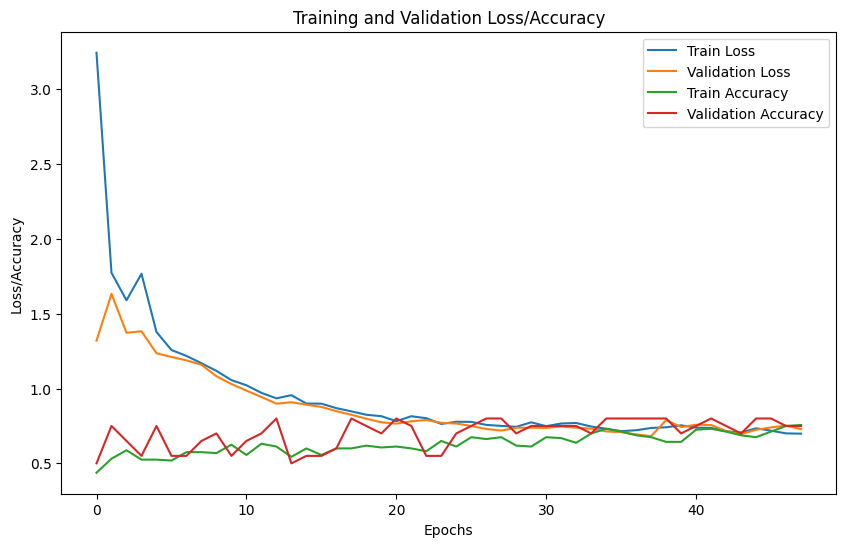

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss/Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
